# Encoding the Audio

In [1]:
import sys 
import os 
import pickle 
import numpy as np
import spacy
import seaborn as sns
import matplotlib as plt 
import matplotlib.pyplot as plt 
import pandas as pd

sys.path.append(os.path.abspath("../lingpred_new/"))
from plotting import colours
from encoding_analysis import regress_out_one, make_arbitrary_static_vectors, brainscore_no_coef
from utils import get_words_onsets_offsets, get_indices_per_task, make_y_matrix_per_run, get_runs


In [130]:
dataset               = 'Armeni' # or Armeni
use_real_word_offsets = True

# dummy variables needed for that get_run functions
session = 1
subject = 1
task    = '0'

# Let's get X matrices for arbitrary vectors:
runs     = get_runs(dataset, session, subject, task)
words_df = pd.DataFrame() 

for run in runs:
    if len(runs)==1:
        words_df = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
    else: 
        temp     = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
        words_df = pd.concat([words_df, temp])
        
X        = make_arbitrary_static_vectors(words_df, dim=300)

# make an X matrix with residualised vectors
X_residualised = regress_out_one(X)
X.shape, X_residualised.shape


((8622, 300), (8621, 300))

In [131]:
# load the acoustic model:

if use_real_word_offsets:     
    if dataset == 'Armeni':
        with open('../audio/{}/acoustic_model_8_mels_averaged_per_word.pkl'.format(dataset), 'rb') as f:
            acoustics = pickle.load(f)
    elif dataset == 'Goldstein':
        with open('../audio/{}/acoustic_model_8_mels_averaged_per_word_using_word_offsets.pkl'.format(dataset), 'rb') as f:
            acoustics = pickle.load(f)
else:   
    with open('../audio/{}/acoustic_model_8_mels_averaged_per_word_using_next_word_onset_as_offset.pkl'.format(dataset), 'rb') as f:
        acoustics = pickle.load(f)

acoustics.shape

(85719, 9)

In [132]:
'''
# Compute the indices for making the y matrix
# -------------------------------------------
# This is already saved under audio/Goldstein/indices_all_tasks.pkl
# No need to run this again, as this would take  approx. 10 min

indices = get_indices_per_task(dataset)
indices.shape

dir_path = '/Users/ines/research/Lingpred/audio/Goldstein/'
file_name = 'indices_all_tasks.pkl'
path      = dir_path + file_name

print(path)
f = open(path,"wb")
pickle.dump(indices, f)
f.close()

'''

# load the indices:
if dataset == 'Goldstein':
    with open('../audio/Goldstein/indices_all_tasks.pkl', 'rb') as f:
        indices = pickle.load(f)
if dataset == 'Armeni':
    with open('../audio/Armeni/indices_session_1.pkl', 'rb') as f:
        indices = pickle.load(f)


indices.shape

(8622, 157)

In [133]:
# check that they look alright:
indices[:1], indices[-1:]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 4]]),
 array([[8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621,
         8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621,
         8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621,
         8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621,
         8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621,
         8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621, 8621,
    

In [134]:
# use indices to make an acoustic y matrix of shape (length, 157, dim)
y_acoustics = make_y_matrix_per_run(acoustics, indices)
y_acoustics.shape

(8622, 157, 9)

In [135]:
y_acoustics[0, 0:10, 0] # check the first 9 values for the first timepoint/word

array([-2.68314075, -2.68314075, -2.68314075, -2.68314075, -2.68314075,
       -2.68314075, -2.68314075, -2.68314075, -2.68314075, -2.68314075])

In [136]:
words_df.head(9)


,onset,duration,sample,type,word,offset
3,1.089189,0.129705,46637.372038,word_onset_01,THE,1.218895
6,1.218895,0.678458,46793.018296,word_onset_01,ADVENTURES,1.897353
15,1.897353,0.089796,47607.167956,word_onset_01,OF,1.987149
18,1.987149,0.488889,47714.923058,word_onset_01,SHERLOCK,2.476037
24,2.476037,0.698413,48301.589725,word_onset_01,HOLMES,3.174450
31,3.912772,0.149660,50025.671358,word_onset_01,A,4.062432
33,4.062432,0.698413,50205.263194,word_onset_01,SCANDAL,4.760845
43,4.940437,0.229478,51258.868636,word_onset_01,IN,5.169915
46,5.169915,0.558730,51534.242786,word_onset_01,BOHEMIA,5.728645


In [137]:
nlp     = spacy.load('en_core_web_lg')
X_Glove = np.vstack([nlp(word).vector for word in words_df.word]) # np array of shape (nr_words, 300)
PoS     = [nlp(word)[0].pos_ for word in words_df.word]
#X_Glove = np.array(X_Glove.get()) # transform from cupy to numpy array for stacking later on 


X_Glove_residualised = regress_out_one(X_Glove)
X_Glove.shape, X_Glove_residualised.shape
    

((8622, 300), (8621, 300))

In [10]:
# compute encoding for residual GloVe and arbitrary vectors:
y = y_acoustics[1:]
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)
print('y should be of shape: (nr_mels, nr_words, nr_timepoints')
print('y has shape ', y.shape)

encoding_arbitrary_residualised = brainscore_no_coef(X_residualised, y)
encoding_Glove_residualised     = brainscore_no_coef(X_Glove_residualised, y)

y should be of shape: (nr_mels, nr_words, nr_timepoints
y has shape  (9, 8621, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8621, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8621, 157)


In [11]:
# compute encoding for original GloVe and arbitrary vectors:
y = y_acoustics
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)
print('y should be of shape: (nr_mels, nr_words, nr_timepoints')
print('y has shape ', y.shape)

encoding_arbitrary = brainscore_no_coef(X, y)
encoding_Glove     = brainscore_no_coef(X_Glove, y)

y should be of shape: (nr_mels, nr_words, nr_timepoints
y has shape  (9, 8622, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8622, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8622, 157)


In [12]:
if dataset == 'Goldstein':  
    with open('../audio/Goldstein/X_GPT_original_and_residualised_layer_47.pkl', 'rb') as f:
        X_matrices_GPT = pickle.load(f)
if dataset == 'Armeni':
    with open('../audio/Armeni/X_y_matrices_Glove_GPT_arbitrary_session_1.pkl', 'rb') as f:
        X_matrices_GPT = pickle.load(f)
X_matrices_GPT.keys()

dict_keys(['y_Glove', 'X_Glove', 'y_GPT', 'X_GPT', 'y_arbitrary', 'X_arbitrary'])

In [13]:
if dataset == 'Armeni':
    X_GPT              = X_matrices_GPT['X_GPT']
    X_GPT_residualised = regress_out_one(X_GPT)
if dataset == 'Goldstein':
    X_GPT              = X_matrices_GPT['X_GPT_layer_47']
    X_GPT_residualised = X_matrices_GPT['X_GPT_residualised_layer_47']


In [14]:
# compute encoding for GPT both regressed out and original GPT:
y = y_acoustics
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)

encoding_GPT  = brainscore_no_coef(X_GPT, y)

y                         = np.swapaxes(np.swapaxes(y_acoustics[1:], 0, 1), 0, 2)
encoding_GPT_residualised = brainscore_no_coef(X_GPT_residualised, y)

We are now in the brainscore_no_coef method, and y has shape:
(9, 8622, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8621, 157)


In [15]:
# Let's save the results with original vectors in one file:
directory = '../audio/{}/'.format(dataset)
file_name = 'vectors_GPT_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_GPT', 'corr_Glove', 'corr_arbitrary']
values  = [encoding_GPT, encoding_Glove, encoding_arbitrary]
results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(results, f)
f.close()


# Let's save the regressed out result in one file:
directory = '../audio/{}/'.format(dataset)
file_name = 'regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_GPT','corr_Glove', 'corr_arbitrary']
values  = [encoding_GPT_residualised, encoding_Glove_residualised, encoding_arbitrary_residualised]
res_results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(res_results, f)
f.close()

../audio/Armeni/vectors_GPT_Glove_arbitrary_y_matrix_like_selfpred.pkl
../audio/Armeni/regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl


## Plots

In [19]:
from plotting import times_100, lowerCI, upperCI, reshape

Text(0.5, 1.0, 'Armeni:')

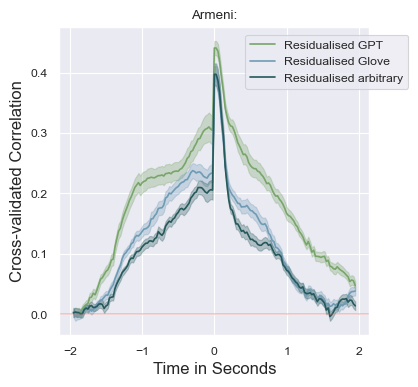

In [21]:
# get model names
models = [k.split(sep='_')[1] for k in results.keys()]
labels = ['Residualised ' + m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(res_results.keys()):
    ax1.plot(times_100, res_results[key].mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(res_results[key])), 
                                upperCI(reshape(res_results[key])), color=colours[models[i]], alpha=0.3)

ax1.legend(loc=(0.6,0.8))
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+':')

Text(0.5, 1.0, 'Armeni:')

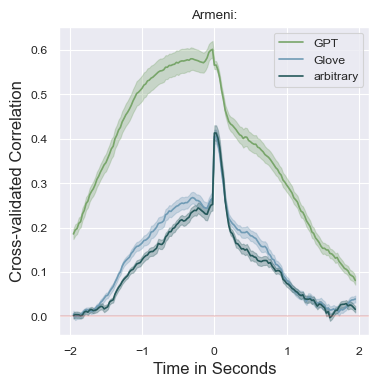

In [22]:
# get model names
models = [k.split(sep='_')[1] for k in res_results.keys()]
labels = [m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(results.keys()):
    ax1.plot(times_100, results[key].mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(results[key])), 
                                upperCI(reshape(results[key])), color=colours[models[i]], alpha=0.3)

ax1.legend()
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+':' )

### Histogram of the difference in values when encoding from residualised vs. original vectors

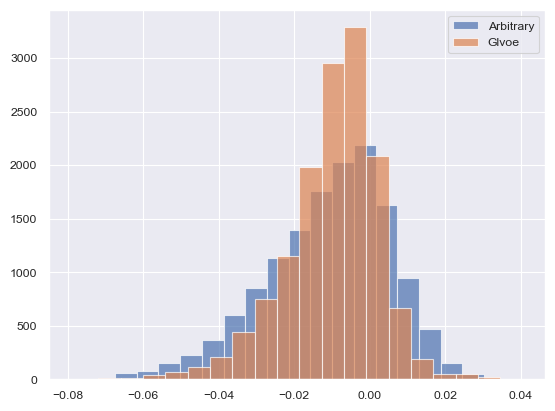

In [18]:
diff = encoding_arbitrary_residualised - encoding_arbitrary
diff.flatten().shape
plt.hist(diff.flatten(), bins=20, alpha=0.7, label='Arbitrary')
diff = encoding_Glove_residualised - encoding_Glove
diff.flatten().shape
plt.hist(diff.flatten(), bins=20, alpha=0.7, label='Glvoe')
plt.legend()

### Arbitrary encoding: Residualised vs. Orignial vectors

Text(0.5, 1.0, 'Armeni: arbitrary')

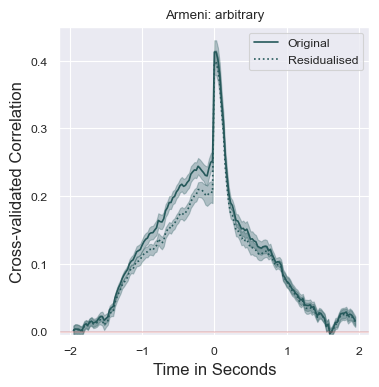

In [23]:
# get model names
models = ['arbitrary', 'arbitrary']
labels = ['Original', 'Residualised']
linestyles = {'Original': '-', 'Residualised': ':'}
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_arbitrary, encoding_arbitrary_residualised]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i], linestyle=linestyles[labels[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + models[0])

### GloVe encoding: Residualised vs. Original Vectors 

Text(0.5, 1.0, 'Armeni: Glove')

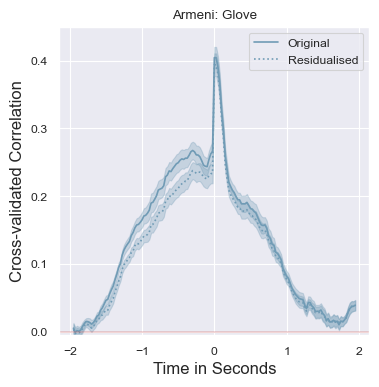

In [24]:
# get model names
models = ['Glove', 'Glove']
labels = ['Original', 'Residualised']
linestyles = {'Original': '-', 'Residualised': ':'}
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove, encoding_Glove_residualised]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i], linestyle=linestyles[labels[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + models[0])

Text(0.5, 1.0, 'Armeni: GPT')

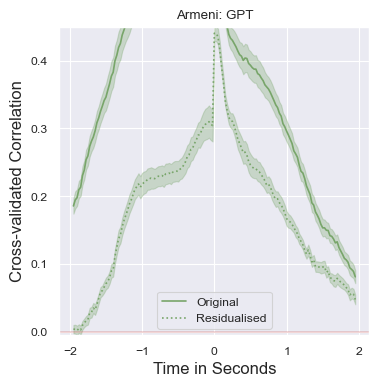

In [25]:
# get model names
models = ['GPT', 'GPT']
labels = ['Original', 'Residualised']
linestyles = {'Original': '-', 'Residualised': ':'}
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_GPT, encoding_GPT_residualised]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i], linestyle=linestyles[labels[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + models[0])

## Difference of Predictability on encoding 

In [139]:
if dataset == 'Armeni':
    with open('../audio/Armeni/Dataframe_WordSurprisal_Top10Words_All_Sessions.pkl', 'rb') as f:
        df = pickle.load(f)
df.head(10)

,Word_from_BPE,Word_in_Annotation,Probability,Surprisal,is_Top_1,is_Top_10,Session_ID,Trial_in_Session,Top_10_Words,Top_10_Probs,is_Top_5,is_Top_3
0,THE,THE,0.000001,13.512426,True,True,1,0,"[The, In, A, I, This, It, But, If, We, As]","[0.0389113575220108, 0.010543630458414555, 0.0...",True,True
1,ADV,ADVENTURES,0.000685,7.285918,False,False,1,1,"[ M, SEC, CH, S, F, A, B, T, AN, C]","[0.014792617410421371, 0.013728495687246323, 0...",False,False
2,OF,OF,0.882994,0.124437,True,True,1,2,"[ OF, IN, of, AND, THAT, ARE, FROM, CON...","[0.8829938769340515, 0.021373802796006203, 0.0...",True,True
3,SH,SHERLOCK,0.006021,5.112506,False,False,1,3,"[ THE, B, L, H, A, M, S, K, T, R]","[0.11832969635725021, 0.022486736997961998, 0....",False,False
4,HOL,HOLMES,0.794207,0.230411,True,True,1,4,"[ HOL, Holmes, B, AND, H, P, PR, G, BE...","[0.7942072153091431, 0.05257217213511467, 0.01...",True,True
5,A,A,0.002268,6.088828,False,False,1,5,"[ AND, IN, THE, ON, BY, and, is, The, ...","[0.058278679847717285, 0.012815546244382858, 0...",False,False
6,SC,SCANDAL,0.005927,5.128182,False,False,1,6,"[ NEW, new, SH, few, B, SER, F, series,...","[0.03229052945971489, 0.02209748513996601, 0.0...",False,False
7,IN,IN,0.051594,2.964345,False,True,1,7,"[OUS, OF, IN, THAT, TO, IS, WITH, AND, ...","[0.3035895824432373, 0.14164458215236664, 0.05...",True,True
8,B,BOHEMIA,0.023277,3.760286,False,True,1,8,"[ THE, A, L, B, P, WH, T, TWO, AN, TIME]","[0.21996444463729858, 0.11218860000371933, 0.0...",False,False
9,To,TO,0.000053,9.842319,False,False,1,9,"[ AND, IS, A, H, IN, B, W, HAS, CON, ...","[0.03238389268517494, 0.022297991439700127, 0....",False,False


In [141]:
if dataset == 'Goldstein':
    df = pd.read_csv('../Goldstein_gpt_features/transcript_data_gpt.txt', 
                                sep='\t',
                                index_col='Unnamed: 0')
    # first we only want to keep the word-initial token of a word:
    mask_first = df["word_idx"] != df["word_idx"].shift(1)
    df_first   = df[mask_first]

    is_top_1     = [x < 1 for x in df_first['rank']] # rank 0 is the Top-1 prediction
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = [x < 5 for x in df_first['rank']] # rank 4 is the Top-5 prediction
    is_not_top_5 = [not x for x in is_top_5]

if dataset == 'Armeni':
    with open('../audio/Armeni/Dataframe_WordSurprisal_Top10Words_All_Sessions.pkl', 'rb') as f:
        df = pickle.load(f)
    is_top_1 = df.is_Top_1.to_list()[:X_Glove.shape[0]]
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = df.is_Top_5.to_list()[:X_Glove.shape[0]]
    is_not_top_5 = [not x for x in is_top_5]

print(np.unique(is_top_1, return_counts=True))
print(np.unique(is_top_5, return_counts=True))

(array([False,  True]), array([5547, 3075]))
(array([False,  True]), array([3568, 5054]))


In [18]:
'''Alternative way of defining Top-1 and Top-5 for Goldstein '''

if dataset == 'Goldstein':
    # group by word_idx
    groups = df.groupby("word_idx")

    # condition: for each word_idx, check if ALL ranks are 0
    mask_all_zero = groups["rank"].transform(lambda x: (x == 0).all())
    mask_all_less_5 = groups["rank"].transform(lambda x: (x < 5).all())  

    len(mask_all_zero[mask_first])
    np.unique(mask_all_zero[mask_first], return_counts=True), np.unique(mask_all_less_5[mask_first], return_counts=True)

This means we have 1485 trials in which the word-initial token is the Top-1 predictions and 2604 trials for which it is among the Top-5 predictions

In [19]:
y_acoustics.shape, X_Glove_residualised.shape, len(is_top_1)

((8622, 157, 9), (8621, 300), 8622)

### First for the original vectors:

In [20]:
y = y_acoustics

X_Glove_top_1     = X_Glove[is_top_1]
X_Glove_top_5     = X_Glove[is_top_5]
X_Glove_not_top_1 = X_Glove[is_not_top_1]
X_Glove_not_top_5 = X_Glove[is_not_top_5]

y_top_1     = y[is_top_1]
y_top_5     = y[is_top_5]
y_not_top_1 = y[is_not_top_1]
y_not_top_5 = y[is_not_top_5]

y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

In [21]:
# compute the encoding of the acoustics for each split
encoding_Glove_top_1     = brainscore_no_coef(X_Glove_top_1, y_top_1)
encoding_Glove_top_5     = brainscore_no_coef(X_Glove_top_5, y_top_5)
encoding_Glove_not_top_1 = brainscore_no_coef(X_Glove_not_top_1, y_not_top_1)
encoding_Glove_not_top_5 = brainscore_no_coef(X_Glove_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 3075, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5054, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5547, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3568, 157)


### and now for the residualised ones:

In [37]:
# Since we are working with residualised vectors, which is not defined for the first word, we need to drop that for our is_top_ masks
y = y_acoustics[1:]

is_top_1     = is_top_1[1:]
is_top_5     = is_top_5[1:]
is_not_top_1 = is_not_top_1[1:]
is_not_top_5 = is_not_top_5[1:]

len(is_top_1), len(is_top_5), len(is_not_top_1), len(is_not_top_5), y.shape

(8621, 8621, 8621, 8621, (8621, 157, 9))

In [38]:
y_top_1     = y[is_top_1]
y_top_5     = y[is_top_5]
y_not_top_1 = y[is_not_top_1]
y_not_top_5 = y[is_not_top_5]

X_Glove_residualised_top_1     = X_Glove_residualised[is_top_1]
X_Glove_residualised_top_5     = X_Glove_residualised[is_top_5]
X_Glove_residualised_not_top_1 = X_Glove_residualised[is_not_top_1]
X_Glove_residualised_not_top_5 = X_Glove_residualised[is_not_top_5]

y_top_1.shape, X_Glove_residualised_top_1.shape

((3074, 157, 9), (3074, 300))

In [39]:
y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

In [40]:
# compute the encoding of the acoustics for each split
encoding_Glove_residualised_top_1     = brainscore_no_coef(X_Glove_residualised_top_1, y_top_1)
encoding_Glove_residualised_top_5     = brainscore_no_coef(X_Glove_residualised_top_5, y_top_5)
encoding_Glove_residualised_not_top_1 = brainscore_no_coef(X_Glove_residualised_not_top_1, y_not_top_1)
encoding_Glove_residualised_not_top_5 = brainscore_no_coef(X_Glove_residualised_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 3074, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5053, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5547, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3568, 157)


Text(0.5, 1.0, 'Armeni Audio Encoding from Residual Vectors: Top 1')

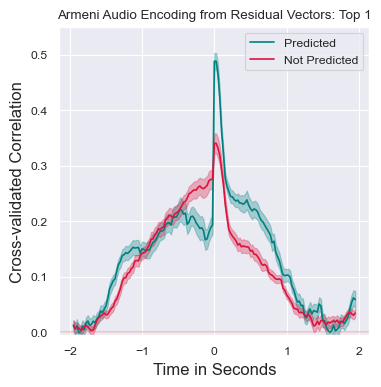

In [43]:
# get model names
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_1, encoding_Glove_residualised_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding from Residual Vectors: ' + models[0])

Text(0.5, 1.0, 'Armeni Audio Encoding: Original Vectors Top 1')

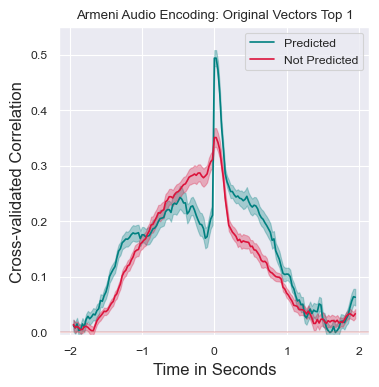

In [45]:
# get model names
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_1, encoding_Glove_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: Original Vectors ' + models[0])

Text(0.5, 1.0, 'Armeni Audio Encoding: ResidualTop 5')

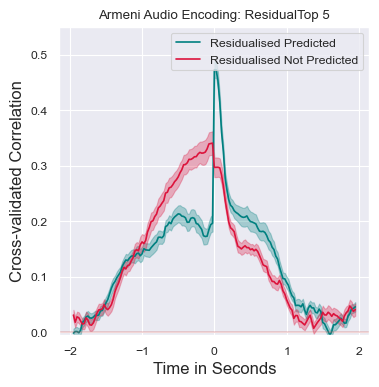

In [46]:
# get model names
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_5, encoding_Glove_residualised_not_top_5]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label='Residualised ' +labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: Residual' + models[0])

### Look at the PoS distribution in each split

In [50]:
len(PoS), len(words_df), len(is_top_1)

(8622, 8622, 8621)

In [51]:
if dataset == 'Goldstein':
    df = pd.read_csv('../Goldstein_gpt_features/transcript_data_gpt.txt', 
                                sep='\t',
                                index_col='Unnamed: 0')
    # first we only want to keep the word-initial token of a word:
    mask_first = df["word_idx"] != df["word_idx"].shift(1)
    df_first   = df[mask_first]

    is_top_1     = [x < 1 for x in df_first['rank']] # rank 0 is the Top-1 prediction
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = [x < 5 for x in df_first['rank']] # rank 4 is the Top-5 prediction
    is_not_top_5 = [not x for x in is_top_5]

if dataset == 'Armeni':
    with open('../audio/Armeni/Dataframe_WordSurprisal_Top10Words_All_Sessions.pkl', 'rb') as f:
        df = pickle.load(f)
    is_top_1 = df.is_Top_1.to_list()[:X_GPT.shape[0]]
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = df.is_Top_5.to_list()[:X_GPT.shape[0]]
    is_not_top_5 = [not x for x in is_top_5]

print(np.unique(is_top_1, return_counts=True))
print(np.unique(is_top_5, return_counts=True))

(array([False,  True]), array([5547, 3075]))
(array([False,  True]), array([3568, 5054]))


In [52]:
PoS_top_1     = np.array(PoS)[is_top_1]
PoS_not_top_1 = np.array(PoS)[is_not_top_1]

len(PoS_top_1), len(PoS_not_top_1)

(3075, 5547)

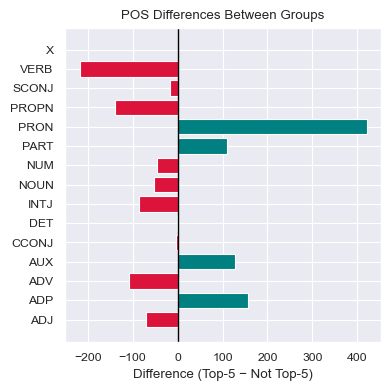

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Count frequencies
counts_top1 = Counter(PoS_top_1)
counts_not_top1 = Counter(PoS_not_top_1)

# Union of all POS tags
all_tags = sorted(set(counts_top1.keys()) | set(counts_not_top1.keys()))

# Align counts
top1_vals = np.array([counts_top1.get(tag, 0) for tag in all_tags])
not_top1_vals = np.array([counts_not_top1.get(tag, 0) for tag in all_tags])

# Option 1: difference in counts
diff_vals = top1_vals - not_top1_vals

# Option 2: difference in proportions (uncomment if you prefer)
# top1_vals = top1_vals / top1_vals.sum()
# not_top1_vals = not_top1_vals / not_top1_vals.sum()
# diff_vals = top1_vals - not_top1_vals

# Plot
y = np.arange(len(all_tags))

plt.figure(figsize=(4, 4))
bars = plt.barh(y, diff_vals, color=["teal" if v > 0 else "crimson" for v in diff_vals])

plt.yticks(y, all_tags)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Difference (Top-5 − Not Top-5)")
plt.title("POS Differences Between Groups")
plt.tight_layout()
plt.show()


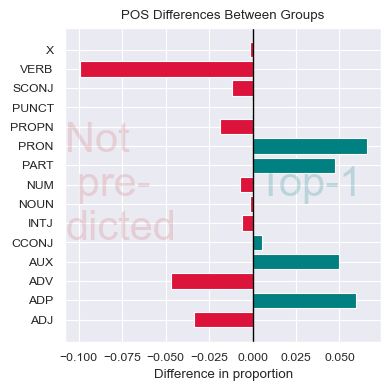

In [53]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Count frequencies
counts_top1     = Counter(PoS_top_1)
counts_not_top1 = Counter(PoS_not_top_1)

# Union of all POS tags
all_tags = sorted(set(counts_top1.keys()) | set(counts_not_top1.keys()))

# Align counts
top1_vals = np.array([counts_top1.get(tag, 0) for tag in all_tags])
not_top1_vals = np.array([counts_not_top1.get(tag, 0) for tag in all_tags])

# Normalise to proportions
top1_vals     = top1_vals / top1_vals.sum()
not_top1_vals = not_top1_vals / not_top1_vals.sum()
diff_vals     = top1_vals - not_top1_vals

# Plot
y       = np.arange(len(all_tags))
fig, ax = plt.subplots(figsize=(4, 4))

ax.barh(y, diff_vals, color=["teal" if v > 0 else "crimson" for v in diff_vals])

ax.set_yticks(y)
ax.set_yticklabels(all_tags)
ax.axvline(0, color="black", linewidth=1)

ax.set_xlabel("Difference in proportion")
ax.set_title("POS Differences Between Groups")

# Get limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add background text
ax.text(xlim[1]*0.85, (ylim[0]+ylim[1])/2, "Top-1",
        ha="right", va="center", fontsize=30, color="teal", alpha=0.2, rotation=0)
ax.text(xlim[0]*1, (ylim[0]+ylim[1])/2, "Not \n pre- \ndicted",
        ha="left", va="center", fontsize=30, color="indianred", alpha=0.2, rotation=0)

plt.tight_layout()
plt.show()


In [54]:
if dataset == 'Goldstein':
    words_df['duration'] = words_df.end - words_df.onset
words_df

,onset,duration,sample,type,word,offset
3,1.089189,0.129705,4.663737e+04,word_onset_01,THE,1.218895
6,1.218895,0.678458,4.679302e+04,word_onset_01,ADVENTURES,1.897353
15,1.897353,0.089796,4.760717e+04,word_onset_01,OF,1.987149
18,1.987149,0.488889,4.771492e+04,word_onset_01,SHERLOCK,2.476037
24,2.476037,0.698413,4.830159e+04,word_onset_01,HOLMES,3.174450
...,...,...,...,...,...,...
41115,425.853815,0.548753,5.577619e+06,word_onset_07,HONOURABLE,426.402568
41123,426.402568,0.838095,5.578278e+06,word_onset_07,TITLE,427.240663
41131,428.058804,0.089796,5.580265e+06,word_onset_07,OF,428.148600
41134,428.148600,0.419048,5.580373e+06,word_onset_07,THE,428.567647


In [55]:
print(words_df[is_top_1].duration.mean(), words_df[is_top_1].duration.var())
print(words_df[is_not_top_1].duration.mean(), words_df[is_not_top_1].duration.var())


0.22931946978707637 0.02772627521099224
0.3070882628640193 0.03511334888635475


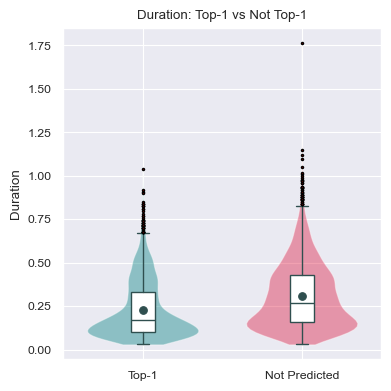

In [57]:
import matplotlib.pyplot as plt
import numpy as np

dur_top1 = words_df[is_top_1].duration.values
dur_not_top1 = words_df[is_not_top_1].duration.values

data = [dur_top1, dur_not_top1]
labels = ["Top-1", "Not Predicted"]

fig, ax = plt.subplots(figsize=(4,4))

for i, vals in enumerate(data, start=1):
    # violin
    parts = ax.violinplot(vals, positions=[i], showextrema=False, widths=0.7)
    for pc in parts['bodies']:
        pc.set_facecolor("teal" if i==1 else "crimson")
        pc.set_alpha(0.4)
    
    # boxplot
    box = ax.boxplot(vals, positions=[i], widths=0.15, patch_artist=True,
                     boxprops=dict(facecolor="white", color="darkslategrey"),
                     medianprops=dict(color="darkslategrey"),
                     whiskerprops=dict(color="darkslategrey"),
                     capprops=dict(color="darkslategrey"),
                     flierprops = dict(
                                        marker=".",
                                        markersize=3,
                                        markerfacecolor="red",
                                        linestyle="none"
                    ))
    
    # mean as a dot
    ax.scatter(i, np.mean(vals), color="darkslategrey", zorder=3, s=30)

ax.set_xticks([1,2])
ax.set_xticklabels(labels)
ax.set_ylabel("Duration")
ax.set_title("Duration: Top-1 vs Not Top-1")
plt.tight_layout()
plt.show()


### For each split, look at what type of words are in the pre-onset interval

In [58]:
preonset_indices = indices[:,:78]
preonset_indices.shape

(8622, 78)

In [59]:
preonset_indices_top_1     = preonset_indices[is_top_1]
preonset_indices_not_top_1 = preonset_indices[is_not_top_1]
nr_words_preonset_top_1     = [len(np.unique(x)) for x in preonset_indices_top_1]
nr_words_preonset_not_top_1 = [len(np.unique(x)) for x in preonset_indices_not_top_1]

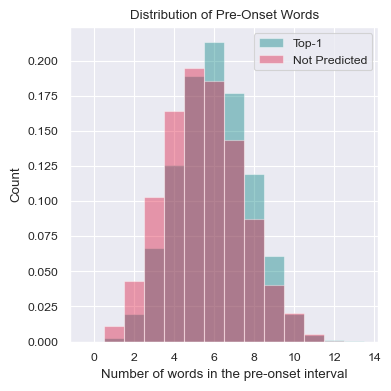

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.hist(nr_words_preonset_top_1, bins=range(0, max(max(nr_words_preonset_top_1),
                                                    max(nr_words_preonset_not_top_1))+2),
         density=True, alpha=0.4, label="Top-1", color="teal", align="left")
plt.hist(nr_words_preonset_not_top_1, bins=range(0, max(max(nr_words_preonset_top_1),
                                                        max(nr_words_preonset_not_top_1))+2),
         density=True, alpha=0.4, label="Not Predicted", color="crimson", align="left")

plt.xlabel("Number of words in the pre-onset interval")
plt.ylabel("Count")
plt.title("Distribution of Pre-Onset Words")
plt.legend()
plt.tight_layout()
plt.show()


In [62]:
words_preonset_top_1     = [words_df.word.iloc[x] for x in preonset_indices_top_1.flatten()]
words_preonset_not_top_1 = [words_df.word.iloc[x] for x in preonset_indices_not_top_1.flatten()]

In [63]:
PoS_preonset_top_1     = [nlp(word)[0].pos_ for word in words_preonset_top_1]
PoS_preonset_not_top_1 = [nlp(word)[0].pos_ for word in words_preonset_not_top_1]


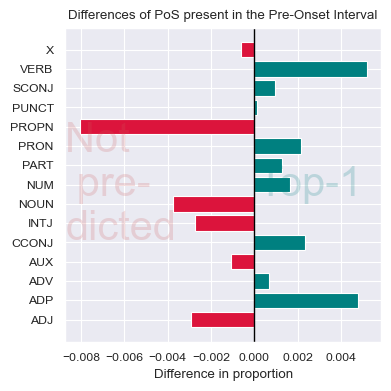

In [65]:
# Count frequencies
counts_top1 = Counter(PoS_preonset_top_1)
counts_not_top1 = Counter(PoS_preonset_not_top_1)

# Union of all POS tags
all_tags = sorted(set(counts_top1.keys()) | set(counts_not_top1.keys()))

# Align counts
top1_vals     = np.array([counts_top1.get(tag, 0) for tag in all_tags])
not_top1_vals = np.array([counts_not_top1.get(tag, 0) for tag in all_tags])

# Normalise to proportions
top1_vals     = top1_vals / top1_vals.sum()
not_top1_vals = not_top1_vals / not_top1_vals.sum()
diff_vals     = top1_vals - not_top1_vals

# Plot
y       = np.arange(len(all_tags))
fig, ax = plt.subplots(figsize=(4, 4))

ax.barh(y, diff_vals, color=["teal" if v > 0 else "crimson" for v in diff_vals])

ax.set_yticks(y)
ax.set_yticklabels(all_tags)
ax.axvline(0, color="black", linewidth=1)

ax.set_xlabel("Difference in proportion")
ax.set_title("Differences of PoS present in the Pre-Onset Interval")

# Get limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add background text
ax.text(xlim[1]*0.85, (ylim[0]+ylim[1])/2, "Top-1",
        ha="right", va="center", fontsize=30, color="teal", alpha=0.2, rotation=0)
ax.text(xlim[0]*1, (ylim[0]+ylim[1])/2, "Not \n pre- \ndicted",
        ha="left", va="center", fontsize=30, color="indianred", alpha=0.2, rotation=0)

plt.tight_layout()
plt.show()


In [66]:
# Let's look at the acoustics themselves, do they look very different??
y_top_1.shape, y_not_top_1.shape

((9, 3074, 157), (9, 5547, 157))

In [67]:
preonset_y_top_1, preonset_y_not_top_1 = y_top_1[:,:,:78], y_not_top_1[:,:,:78]
preonset_y_top_1.shape, preonset_y_not_top_1.shape

((9, 3074, 78), (9, 5547, 78))

In [68]:
preonset_y_top_1[:, 0, 0]

array([ -3.18965149, -16.83115768, -30.60241699, -20.08598518,
       -21.69374657, -32.22709274, -44.04509735, -48.29707336,
       370.1706543 ])

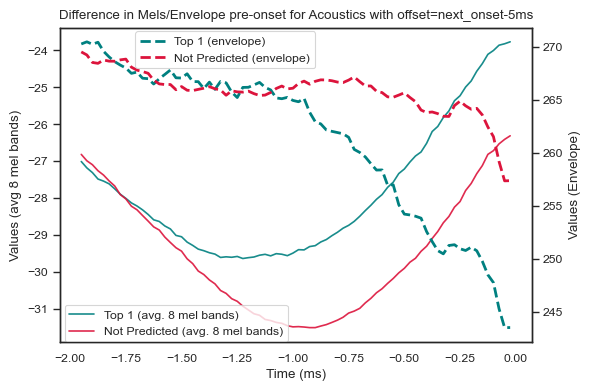

In [77]:

x = times_100[:78]
sns.set_style('white')

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()  # right y-axis

colors = ['teal', 'crimson']
labels = ['Top 1', 'Not Predicted']

for data, color, label in zip([preonset_y_top_1, preonset_y_not_top_1],
                              colors, labels):
    mean = data.mean(axis=1)  # shape (9, 78)
    std = data.std(axis=1)

    # --- Average across first 8 ---
    avg_mean = mean[:8].mean(axis=0)
    avg_std = mean[:8].std(axis=0)

    ax1.plot(x, avg_mean, color=color, alpha=0.9, label=f"{label} (avg. 8 mel bands)")
    #ax1.fill_between(x, avg_mean-avg_std, avg_mean+avg_std, color=color, alpha=0.2)

    # --- Plot the 9th separately ---
    ax2.plot(x, mean[8], color=color, linestyle="--", linewidth=2, label=f"{label} (envelope)")
    #ax2.fill_between(x, mean[8]-std[8], mean[8]+std[8], color=color, alpha=0.15)

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Values (avg 8 mel bands)")
#ax1.set_ylim((-13, -5))
#ax2.set_ylim((126, 182))
ax2.set_ylabel("Values (Envelope)")
ax2.legend(loc=(0.16, 0.87))
ax1.legend(loc=(0.01, 0))
if use_real_word_offsets:
    plt.title('Difference in Mels/Envelope pre-onset for Acoustics with real_word_offsets')
else:
    plt.title('Difference in Mels/Envelope pre-onset for Acoustics with offset=next_onset-5ms')
plt.tight_layout()
plt.show()


## we want to compare bigrams vs. no-bigrams encoding for each dataset to see if that holds for Goldstein
since the bigrams should be more predictable prior to onset than non-bigrams

In [142]:
X_Glove.shape, len(words_df)

((8622, 300), 8622)

In [143]:
def get_bigram_duplicate_mask(df: pd.DataFrame, word_col: str = 'word') -> np.ndarray:
    """
    Returns indices of the first word in each duplicate bigram from a dataframe.
    
    Parameters:
    - df: pandas DataFrame containing a column of words
    - word_col: name of the column containing the words (default is 'word')
    
    Returns:
    - np.ndarray of indices corresponding to the first word of each duplicate bigram
    """

    df = df.copy()
    df['next_word'] = df[word_col].shift(-1)
    df['bigram']    = df[word_col] + '_' + df['next_word']
    df['indx']     = [x+1 for x in range(len(df))] # This column is the index shifted by one, since I am interested in the second word of the bigram. e.g, in the bigram monkey_in I want 'in' to be the time locked at t=0 word
    df_bigrams      = df[:-1].reset_index(drop=True)

    # keep only rows whose bigram occurs more than once
    dup_mask                 = df_bigrams.duplicated('bigram', keep=False)
    duplicate_bigram_indices = df_bigrams[dup_mask].indx

    # compute frequency counts
    bigram_counts = df_bigrams['bigram'].value_counts()
    # map back to dataframe
    df_bigrams['bigram_count'] = df_bigrams['bigram'].map(bigram_counts)

    print(df_bigrams[dup_mask].head(10))

    return duplicate_bigram_indices.to_numpy()

def get_unique_bigram_mask(df: pd.DataFrame, word_col: str = 'word') -> np.ndarray:
    """
    Returns indices of the first word in each duplicate bigram from a dataframe.
    
    Parameters:
    - df: pandas DataFrame containing a column of words
    - word_col: name of the column containing the words (default is 'word')
    
    Returns:
    - np.ndarray of indices corresponding to the first word of each duplicate bigram
    """

    df = df.copy()
    df['next_word'] = df[word_col].shift(-1)
    df['bigram']    = df[word_col] + '_' + df['next_word']
    df['indx']     = [x+1 for x in range(len(df))] # This column is the index shifted by one, since I am interested in the second word of the bigram. e.g, in the bigram monkey_in I want 'in' to be the time locked at t=0 word
    df_bigrams      = df[:-1].reset_index(drop=True)

    # keep only rows whose bigram occurs more than once
    dup_mask                 = df_bigrams.duplicated('bigram', keep=False)
    unique_mask              = [not x for x in dup_mask]
    unique_bigram_indices    = df_bigrams[unique_mask].indx

    # compute frequency counts
    bigram_counts = df_bigrams['bigram'].value_counts()
    # map back to dataframe
    df_bigrams['bigram_count'] = df_bigrams['bigram'].map(bigram_counts)

    print(df_bigrams[unique_mask].head(10))

    return unique_bigram_indices.to_numpy()

bigram_duplicate_mask = get_bigram_duplicate_mask(words_df)
bigram_unique_mask    = get_unique_bigram_mask(words_df)

print(len(bigram_duplicate_mask), len(bigram_unique_mask))

# make lengths equal by random sampling (without replacement)
'''if len(bigram_duplicate_mask) < len(bigram_unique_mask):
    bigram_unique_mask = np.random.choice(
        bigram_unique_mask,
        size=len(bigram_duplicate_mask),
        replace=False
    )
'''
print(len(bigram_duplicate_mask), len(bigram_unique_mask))

        onset  duration        sample           type      word     offset  \
3    1.987149  0.488889  47714.923058  word_onset_01  SHERLOCK   2.476037   
4    2.476037  0.698413  48301.589725  word_onset_01    HOLMES   3.174450   
7    4.940437  0.229478  51258.868636  word_onset_01        IN   5.169915   
9    8.272863  0.169615  55257.780201  word_onset_01        TO   8.442477   
10   8.442477  0.429025  55461.317616  word_onset_01  SHERLOCK   8.871502   
12   9.779439  0.219501  57065.671358  word_onset_01       SHE   9.998940   
13   9.998940  0.209524  57329.072718  word_onset_01        IS  10.208464   
15  11.116400  0.079819  58670.025099  word_onset_01       THE  11.196219   
17  13.052001  0.209524  60992.746187  word_onset_01         I  13.261525   
20  14.019802  0.249433  62154.106732  word_onset_01     HEARD  14.269235   

   next_word           bigram  indx  bigram_count  
3     HOLMES  SHERLOCK_HOLMES     4            11  
4          A         HOLMES_A     5             

In [110]:
y_bigrams        = y_acoustics[bigram_duplicate_mask]
X_Glove_bigrams  = X_Glove[bigram_duplicate_mask]

y_nobigrams        = y_acoustics[bigram_unique_mask]
X_Glove_nobigrams  = X_Glove[bigram_unique_mask]

In [111]:

y_bigrams   = np.swapaxes(np.swapaxes(y_bigrams, 1, 2), 0, 1)
y_nobigrams = np.swapaxes(np.swapaxes(y_nobigrams, 1, 2), 0, 1)

y_bigrams.shape

(9, 1578, 157)

In [112]:

encoding_Glove_bigrams   = brainscore_no_coef(X_Glove_bigrams, y_bigrams)
encoding_Glove_nobigrams = brainscore_no_coef(X_Glove_nobigrams, y_nobigrams)

We are now in the brainscore_no_coef method, and y has shape:
(9, 1578, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3557, 157)


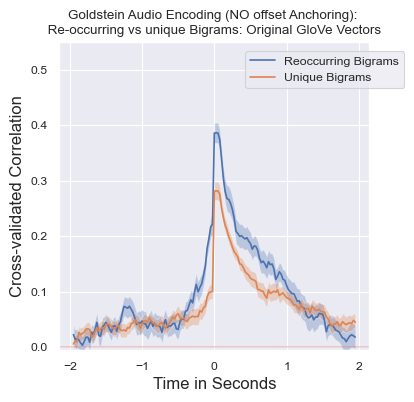

In [114]:
# get model names
from lingpred_new.plotting import times_100, lowerCI, upperCI, reshape

models = ['Reoccurring Bigrams', 'Unique Bigrams']
labels = models
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_bigrams, encoding_Glove_nobigrams]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), alpha=0.3)

ax1.legend(loc=(0.6, 0.85))
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
if use_real_word_offsets:
    ax1.set_title(dataset+' Audio Encoding (NO offset Anchoring): \n Re-occurring vs unique Bigrams: Original GloVe Vectors ')
else:
    ax1.set_title(dataset+' Audio Encoding (OFFSET ANCHORING!): \n Re-occurring vs unique Bigrams: Original GloVe Vectors ')

## Let's look at residualisation and if that has an impact at all 

In order to look at the residual encoding I need to shift all the indices back by one, since the first vector in the residual X matrix corresponds to the second word. E.g.: Act One, Monkey in the Middle. The vector at X[0] is the vector for 'One' for which 'Act' has been regressed out. So if the duplicates mask tells me, keep the vector number 3, corresponding to 'in' since monkey_in is a re-occurring bigram, I now need to keep the regressed out vector for in, which is at the position X[2] not X[3]

In [115]:
bigram_unique_mask_residualised    = [x-1 for x in bigram_unique_mask]
bigram_duplicate_mask_residualised = [x-1 for x in bigram_duplicate_mask]

X_Glove_residualised_bigrams    = X_Glove_residualised[bigram_duplicate_mask_residualised]
X_Glove_residualised_no_bigrams = X_Glove_residualised[bigram_unique_mask_residualised]

X_Glove_residualised_bigrams.shape, X_Glove_residualised_no_bigrams.shape

((1578, 300), (3557, 300))

In [116]:
y_bigrams.shape, y_nobigrams.shape

((9, 1578, 157), (9, 3557, 157))

In [117]:

encoding_Glove_residualised_bigrams   = brainscore_no_coef(X_Glove_residualised_bigrams, y_bigrams)
encoding_Glove_residualised_nobigrams = brainscore_no_coef(X_Glove_residualised_no_bigrams, y_nobigrams)

We are now in the brainscore_no_coef method, and y has shape:
(9, 1578, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3557, 157)


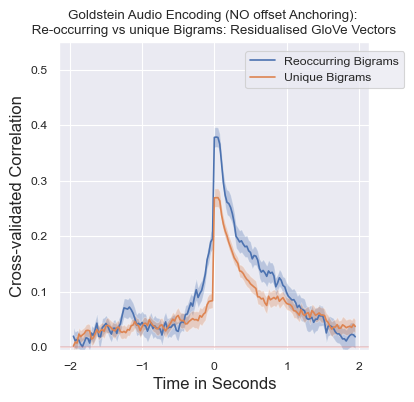

In [119]:

models = ['Reoccurring Bigrams', 'Unique Bigrams']
labels = models
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_bigrams, encoding_Glove_residualised_nobigrams]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), alpha=0.3)

ax1.legend(loc=(0.6, 0.85))
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
if use_real_word_offsets:
    ax1.set_title(dataset+' Audio Encoding (NO offset Anchoring): \n Re-occurring vs unique Bigrams: Residualised GloVe Vectors ')
else:
    ax1.set_title(dataset+' Audio Encoding (OFFSET ANCHORING!): \n Re-occurring vs unique Bigrams: Residualised GloVe Vectors ')

### Let's look at the overlap between our re-occuring bigrams and the Top-1 and Top-5 prediction by GPT

In [144]:
top_1_indices = np.array(range(len(is_top_1)))[is_top_1]
top_1_indices

array([   0,    2,    4, ..., 8616, 8618, 8619], shape=(3075,))

In [147]:
top_1_and_reoccuring_bigram = [x for x in top_1_indices if x in bigram_duplicate_mask]
print("Number reoccurring bigrams which are the Top-1 prediction:", len(top_1_and_reoccuring_bigram))
print("Out of", len(bigram_duplicate_mask))

Number reoccurring bigrams which are the Top-1 prediction: 1665
Out of 3154


In [148]:
top_5_indices = np.array(range(len(is_top_5)))[is_top_5]
top_5_and_reoccuring_bigram = [x for x in top_5_indices if x in bigram_duplicate_mask]

print("Number reoccurring bigrams which are the Top-5 prediction:", len(top_5_and_reoccuring_bigram))
print("Out of ", len(bigram_duplicate_mask))

Number reoccurring bigrams which are the Top-5 prediction: 2478
Out of  3154


## Let's look at what happens when we remove re-occorring bigrams and do the split then:

In [27]:
from lingpred_new.utils import get_bigram_mask

bigram_mask = np.array(get_bigram_mask(words_df))

# apply the mask to all our X, y matrices and other masks
y        = y_acoustics[bigram_mask]
X_Glove_nb  = X_Glove[bigram_mask]
is_top_5_nb = np.array(is_top_5)[bigram_mask]
is_top_1_nb = np.array(is_top_1)[bigram_mask]
is_not_top_5_nb = np.array(is_not_top_5)[bigram_mask]
is_not_top_1_nb = np.array(is_not_top_1)[bigram_mask]


X_Glove_top_1     = X_Glove_nb[is_top_1_nb]
X_Glove_top_5     = X_Glove_nb[is_top_5_nb]
X_Glove_not_top_1 = X_Glove_nb[is_not_top_1_nb]
X_Glove_not_top_5 = X_Glove_nb[is_not_top_5_nb]

y_top_1     = y[is_top_1_nb]
y_top_5     = y[is_top_5_nb]
y_not_top_1 = y[is_not_top_1_nb]
y_not_top_5 = y[is_not_top_5_nb]

y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

       onset  duration        sample           type        word    offset  \
3   1.089189  0.129705  46637.372038  word_onset_01         THE  1.218895   
6   1.218895  0.678458  46793.018296  word_onset_01  ADVENTURES  1.897353   
15  1.897353  0.089796  47607.167956  word_onset_01          OF  1.987149   
18  1.987149  0.488889  47714.923058  word_onset_01    SHERLOCK  2.476037   
24  2.476037  0.698413  48301.589725  word_onset_01      HOLMES  3.174450   

     next_word           bigram  
3   ADVENTURES   THE_ADVENTURES  
6           OF    ADVENTURES_OF  
15    SHERLOCK      OF_SHERLOCK  
18      HOLMES  SHERLOCK_HOLMES  
24           A         HOLMES_A  


In [29]:
len(is_top_1_nb), len(is_top_1)

(6366, 8622)

In [44]:
# print the unique count for each list 
np.unique(is_top_1, return_counts=True), np.unique(is_top_1_nb, return_counts=True)

((array([False,  True]), array([5547, 3074])),
 (array([False,  True]), array([4258, 2107])))

In [28]:
# compute the encoding of the acoustics for each split
encoding_Glove_top_1     = brainscore_no_coef(X_Glove_top_1, y_top_1)
encoding_Glove_top_5     = brainscore_no_coef(X_Glove_top_5, y_top_5)
encoding_Glove_not_top_1 = brainscore_no_coef(X_Glove_not_top_1, y_not_top_1)
encoding_Glove_not_top_5 = brainscore_no_coef(X_Glove_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 2108, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3542, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 4258, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2824, 157)


## ... and now for the residualised vectors without bigrams 

In [35]:
# Since we are working with residualised vectors, which is not defined for the first word, we need to drop that for our is_top_ masks
y = y_acoustics[1:]

is_top_1     = is_top_1[1:]
is_top_5     = is_top_5[1:]
is_not_top_1 = is_not_top_1[1:]
is_not_top_5 = is_not_top_5[1:]

len(is_top_1), len(is_top_5), len(is_not_top_1), len(is_not_top_5), y.shape

(8621, 8621, 8621, 8621, (8621, 157, 9))

In [40]:
bigram_mask = get_bigram_mask(words_df)
bigram_mask_residualised = [x-1 for x in bigram_mask if x>0]
bigram_mask_residualised[:10], len(bigram_mask_residualised)

       onset  duration        sample           type        word    offset  \
3   1.089189  0.129705  46637.372038  word_onset_01         THE  1.218895   
6   1.218895  0.678458  46793.018296  word_onset_01  ADVENTURES  1.897353   
15  1.897353  0.089796  47607.167956  word_onset_01          OF  1.987149   
18  1.987149  0.488889  47714.923058  word_onset_01    SHERLOCK  2.476037   
24  2.476037  0.698413  48301.589725  word_onset_01      HOLMES  3.174450   

     next_word           bigram  
3   ADVENTURES   THE_ADVENTURES  
6           OF    ADVENTURES_OF  
15    SHERLOCK      OF_SHERLOCK  
18      HOLMES  SHERLOCK_HOLMES  
24           A         HOLMES_A  


([np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(4),
  np.int64(5),
  np.int64(6),
  np.int64(7),
  np.int64(8),
  np.int64(10)],
 6365)

In [41]:

# apply the mask to all our X, y matrices and other masks
y                         = y[bigram_mask_residualised]
X_Glove_residualised_nb   = X_Glove_residualised[bigram_mask_residualised]
is_top_5_nb               = np.array(is_top_5)[bigram_mask_residualised]
is_top_1_nb               = np.array(is_top_1)[bigram_mask_residualised]
is_not_top_5_nb           = np.array(is_not_top_5)[bigram_mask_residualised]
is_not_top_1_nb           = np.array(is_not_top_1)[bigram_mask_residualised]


# split into Top-1, Top-5 and not-Top
X_Glove_residualised_top_1     = X_Glove_residualised_nb[is_top_1_nb]
X_Glove_residualised_top_5     = X_Glove_residualised_nb[is_top_5_nb]
X_Glove_residualised_not_top_1 = X_Glove_residualised_nb[is_not_top_1_nb]
X_Glove_residualised_not_top_5 = X_Glove_residualised_nb[is_not_top_5_nb]

y_top_1     = y[is_top_1_nb]
y_top_5     = y[is_top_5_nb]
y_not_top_1 = y[is_not_top_1_nb]
y_not_top_5 = y[is_not_top_5_nb]

# swapping y matrices to the right shape
y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

# compute the encoding of the acoustics for each split
encoding_Glove_residualised_top_1     = brainscore_no_coef(X_Glove_residualised_top_1, y_top_1)
encoding_Glove_residualised_top_5     = brainscore_no_coef(X_Glove_residualised_top_5, y_top_5)
encoding_Glove_residualised_not_top_1 = brainscore_no_coef(X_Glove_residualised_not_top_1, y_not_top_1)
encoding_Glove_residualised_not_top_5 = brainscore_no_coef(X_Glove_residualised_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 2107, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3541, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 4258, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2824, 157)


## Plotting

Text(0.5, 1.0, 'Armeni Audio Encoding: No Bigrams: Original Vectors Top 1')

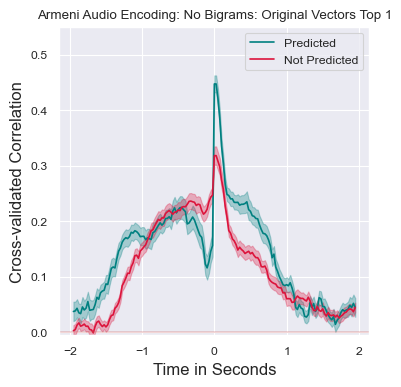

In [33]:
# get model names
from lingpred_new.plotting import times_100, lowerCI, upperCI, reshape

models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_1, encoding_Glove_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: No Bigrams: Original Vectors ' + models[0])

Text(0.5, 1.0, 'Armeni Audio Encoding: No Bigrams: Original Vectors Top 5')

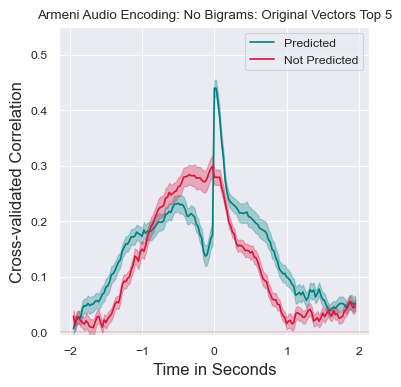

In [34]:
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_5, encoding_Glove_not_top_5]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: No Bigrams: Original Vectors ' + models[0])

Text(0.5, 1.0, 'Armeni Audio Encoding: No Bigrams: Residual Vectors Top 1')

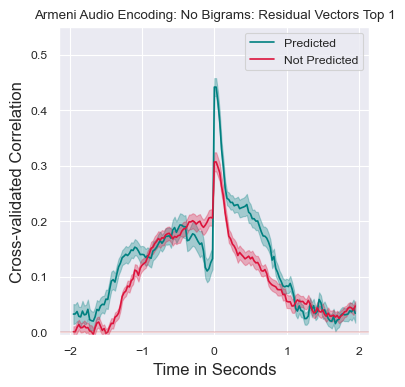

In [42]:

models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_1, encoding_Glove_residualised_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: No Bigrams: Residual Vectors ' + models[0])

Text(0.5, 1.0, 'Armeni Audio Encoding: No Bigrams: Residual Vectors Top 5')

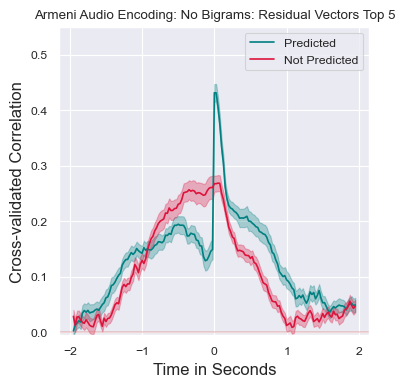

In [43]:

models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_5, encoding_Glove_residualised_not_top_5]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: No Bigrams: Residual Vectors ' + models[0])